# **Lab 1 - Convolutional Neural Networks (CNN)**
The objective of this lab is to cover the following points:



1.   How to design a from-scratch model for a multi-label classification problem
2.   How to use a pre-trained model (like VGG16) to predict ImageNet data classes for new images.
3.   How to fine-tune a pre-trained model on another dataset to predict new classes.

**1- Tutorial on Binary classification**

Start with this tutorial:

https://drive.google.com/file/d/1Y8kgQJVA0BmD3-upKVXIkrd7unh4aIvu/view?usp=sharing

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#To see our directory
import os
import random

In [2]:
# Monter votre Drive afin de pouvoir y'acceder
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# nous supposons que la base d'image se trouve dans le répertoire "IA-Vision" de votre Drive
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Centrale Lille/G3/data_chat.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
# Path assuming the dataset was extracted to the current directory
train_dir = './data/train'
test_dir = './data/validation'

# Get dog images
train_dogs = [f'{train_dir}/{i}' for i in os.listdir(train_dir) if 'dog' in i]
# Get cat images
train_cats = [f'{train_dir}/{i}' for i in os.listdir(train_dir) if 'cat' in i]
# Get test images
test_imgs = [f'{test_dir}/{i}' for i in os.listdir(test_dir)]

train_imgs = train_dogs[:2000] + train_cats[:2000] # slice the dataset and use 2000 in each class
random.shuffle(train_imgs) # shuffle it randomly

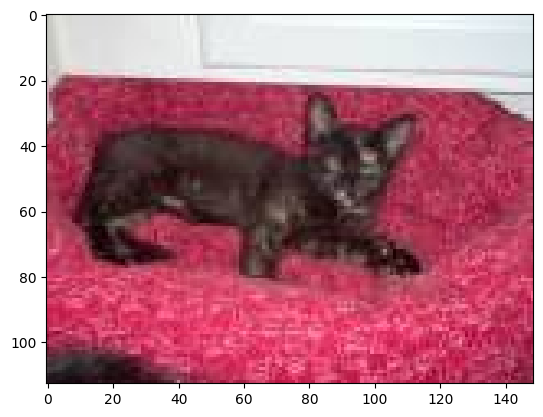

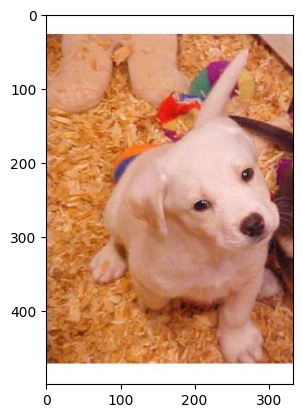

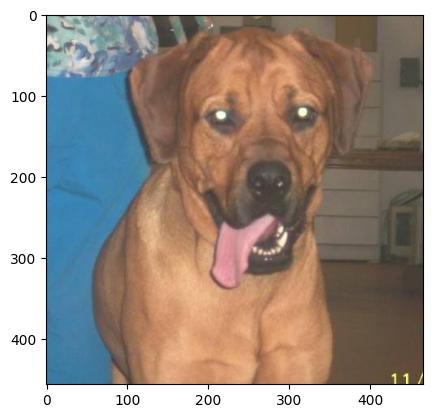

In [5]:
import matplotlib.image as mpimg

for ima in train_imgs[0:3]:
  img = mpimg.imread(ima)
  imgplot = plt.imshow(img)
  plt.show()

In [6]:
# Lets declare our image dimensions
# we are using coloured images.
nrows = 150
ncolumns = 150

channels = 3 # change to 1 if you want to use grayscale image

# A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
  """
  Returns two arrays:
    X is an array of resized images
    y is an array of labels
  """
  X = [] # images
  y = [] # labels
  for image in list_of_images:
    im = cv2.imread(image, cv2.IMREAD_COLOR)
    im2 = cv2.resize(im,(nrows, ncolumns),
    interpolation=cv2.INTER_CUBIC)
    X.append(im2)
    # X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC)) # Read the image
    # get the labels
    if 'dog' in image:
      y.append(1)
    elif 'cat' in image:
      y.append(0)
  return X, y

In [7]:
#get the train and label data
X, y = read_and_process_image(train_imgs)

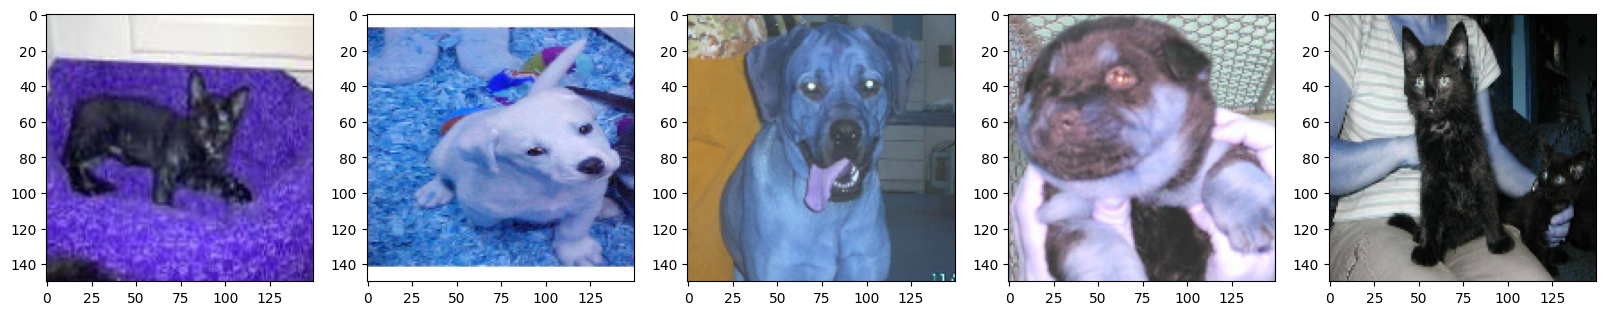

In [8]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
  plt.subplot(int(5 / columns + 1), columns, i + 1)
  imgplot = plt.imshow(X[i])
plt.show()

In [9]:
X = np.array(X)
y = np.array(y)

print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (2048, 150, 150, 3)
Shape of labels is: (2048,)


In [10]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
import gc # Import the garbage collection module

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20,
random_state=2)
print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

Shape of train images is: (1638, 150, 150, 3)
Shape of validation images is: (410, 150, 150, 3)
Shape of labels is: (1638,)
Shape of labels is: (410,)


In [11]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# To create our model, we are going to use an architecture insired from vggnet
# https://arxiv.org/pdf/1409.1556.pdf, in which you can see below that
# our filter size increases as we go down layers
# 32 → 64 →128 →512—and final layer is 1

model = models.Sequential() # (1)
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150,
150, 3)))#(2)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) # (3)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) # (4)
model.add(layers.Dropout(0.5)) #Dropout for regularization # (5)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # (6) #Sigmoid function at the end because we have just two classes

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # Change 'lr' to 'learning_rate'
              metrics=['acc'])

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255) #We do not augment validation data. we only perform rescale

In [15]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

history = model.fit(train_generator,
                              steps_per_epoch=ntrain // batch_size,
    epochs=32, validation_data=val_generator, validation_steps=nval // batch_size)

Epoch 1/32


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 334ms/step - acc: 0.4935 - loss: 0.6969 - val_acc: 0.5312 - val_loss: 0.6907
Epoch 2/32
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - acc: 0.5312 - loss: 0.6959

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.5312 - loss: 0.6959 - val_acc: 0.5769 - val_loss: 0.6903
Epoch 3/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - acc: 0.5208 - loss: 0.6917 - val_acc: 0.4792 - val_loss: 0.6934
Epoch 4/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - acc: 0.5938 - loss: 0.6912 - val_acc: 0.6154 - val_loss: 0.6846
Epoch 5/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - acc: 0.5450 - loss: 0.6888 - val_acc: 0.5755 - val_loss: 0.6877
Epoch 6/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.5625 - loss: 0.6887 - val_acc: 0.5769 - val_loss: 0.6782
Epoch 7/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - acc: 0.5529 - loss: 0.6867 - val_acc: 0.5781 - val_loss: 0.6843
Epoch 8/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - acc: 0.5000 - loss: 0.6910 - val_acc: 0.6538 - val_loss: 0.6598
Epoch 9/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - acc: 0.5795 - loss: 0.6771 - val_acc: 0.5078 - val_loss: 0.6873
Epoch 10/32
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.6562 -

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
NAME = "CNN_FramScratch"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [ ]:
history = model.fit_generator(train_generator,
steps_per_epoch=ntrain // batch_size,

epochs=5,
validation_data=val_generator,
validation_steps=nval // batch_size,
callbacks=[tensorboard])

In [ ]:
%load_ext tensorboard
import datetime
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [ ]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
  pred = model.predict(batch)
  if pred > 0.5:
    text_labels.append('dog')
  else:
    text_labels.append('cat')
  plt.subplot(5 / columns + 1, columns, i + 1)
  plt.title('This is a ' + text_labels[i])
  imgplot = plt.imshow(batch[0])
  i += 1
  if i % 10 == 0:
    break
plt.show()

**2- Multi-Classification on clothe dataset**

**Data upload**

Based on the tutorial above, it is requested to implement a CNN-based network to perform a multi-label classification solution. Download the image dataset "data.zip" available here:
https://drive.google.com/file/d/1uzR8oW7F4ONyptQQeN09MqIa4Oo2An4m/view?usp=sharing).
This dataset contains 8 categories of images distributed as shown in the following structure (in total 22 directories):

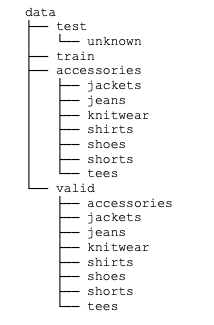

In [1]:
# Monter votre Drive afin de pouvoir y'acceder
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# nous supposons que la base d'image se trouve dans le répertoire "IA-Vision" de votre Drive
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Centrale Lille/G3/data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


**Backage Import**


In [3]:
import os
from tensorflow.keras.layers import Flatten, Dense, Dropout
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

The file is alreday split into three dataset : Train, Validation and Test.

Images are divided in 8 classes :

*   **Accessories**
*   **jackets**
*   **jeans**
*   **knitwear**
*   **shirts**
*   **shoes**
*   **shorts**
*   **tees**

An example of the images in the dataset. All the images have a size of 432x300x3.

(432, 300, 3)


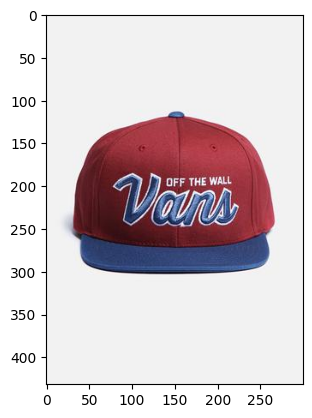

In [4]:
# un exemple de lecture/affichage d'une image
img=plt.imread("/content/data/train/accessories/productimg_1.jpg") # Corrected path
plt.imshow(img)
print(img.shape)

In [5]:
img2 = cv2.resize(cv2.imread("/content/data/train/accessories/productimg_1.jpg"),(150,150),interpolation=cv2.INTER_CUBIC)

**Reading and processing of the images**

We can resize all our images to a size of 266x150x3 (to speed up the training phase).
The labels are one-hot encoded, which means they are represented as an of length n (the number of class) with the value 1 on the associated label index and 0 on the others. The images are shuffled.

Datasets sizes :

*  Train : 3467
*  Validation : 382
*  Test : 8

*NB : the test dataset apppears to be really small. However, we only want to explore methods and not to find the best model for this problem.*  





In [6]:
# Chargement de toutes les images:
path="data/"
train_dir = path+"train/"
test_dir = path+"validation/"
from sklearn.utils import shuffle

# Je redimensionne toutes nos images à une taille de 266x150x3 (surtout pour accélérer la phase d'apprentissage).
# Les étiquettes sont encodées au format one-hot, ce qui signifie qu'elles sont représentées comme un de longueur n (le nombre de classe) avec la valeur 1 sur l'index d'étiquette associé et 0 sur les autres.
# Les images sont mélangées (on utilise pour cela shuffle())

rows=266
columns=150

def read_process(dataset,columns,rows,rand=True):
    labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
    dir=path+dataset+"/"
    X,Y=[],[]
    for j,label in enumerate(labels):
        for file in os.listdir(dir+label+"/"):
            X.append(cv2.resize(cv2.imread(dir+label+"/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
            y=[0 for _ in range(len(labels))]
            y[j]=1
            Y.append(y)
    if rand :
        return shuffle(np.array(X),np.array(Y))
    else:
        return np.array(X),np.array(Y)

def read_process_test(columns,rows):
    X_test=[]
    for file in os.listdir("/content/data/test/unknown"):
        X_test.append(cv2.resize(cv2.imread("/content/data/test/unknown/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
    return np.array(X_test)

X_train,Y_train=read_process("train",columns,rows)
X_val,Y_val=read_process("valid",columns,rows)
X_test=read_process_test(150,266)

Next, let's check the shape of our data. We can see that our train images are a rank 4 tensor, or we could say a 4 dimensional array with dimensions 3467 x 266 x 150 x 3 which respectively correspond to the size, height, width and channels of the lot.

In [7]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape)

(3467, 266, 150, 3) (3467, 8)
(382, 266, 150, 3) (382, 8)
(8, 266, 150, 3)


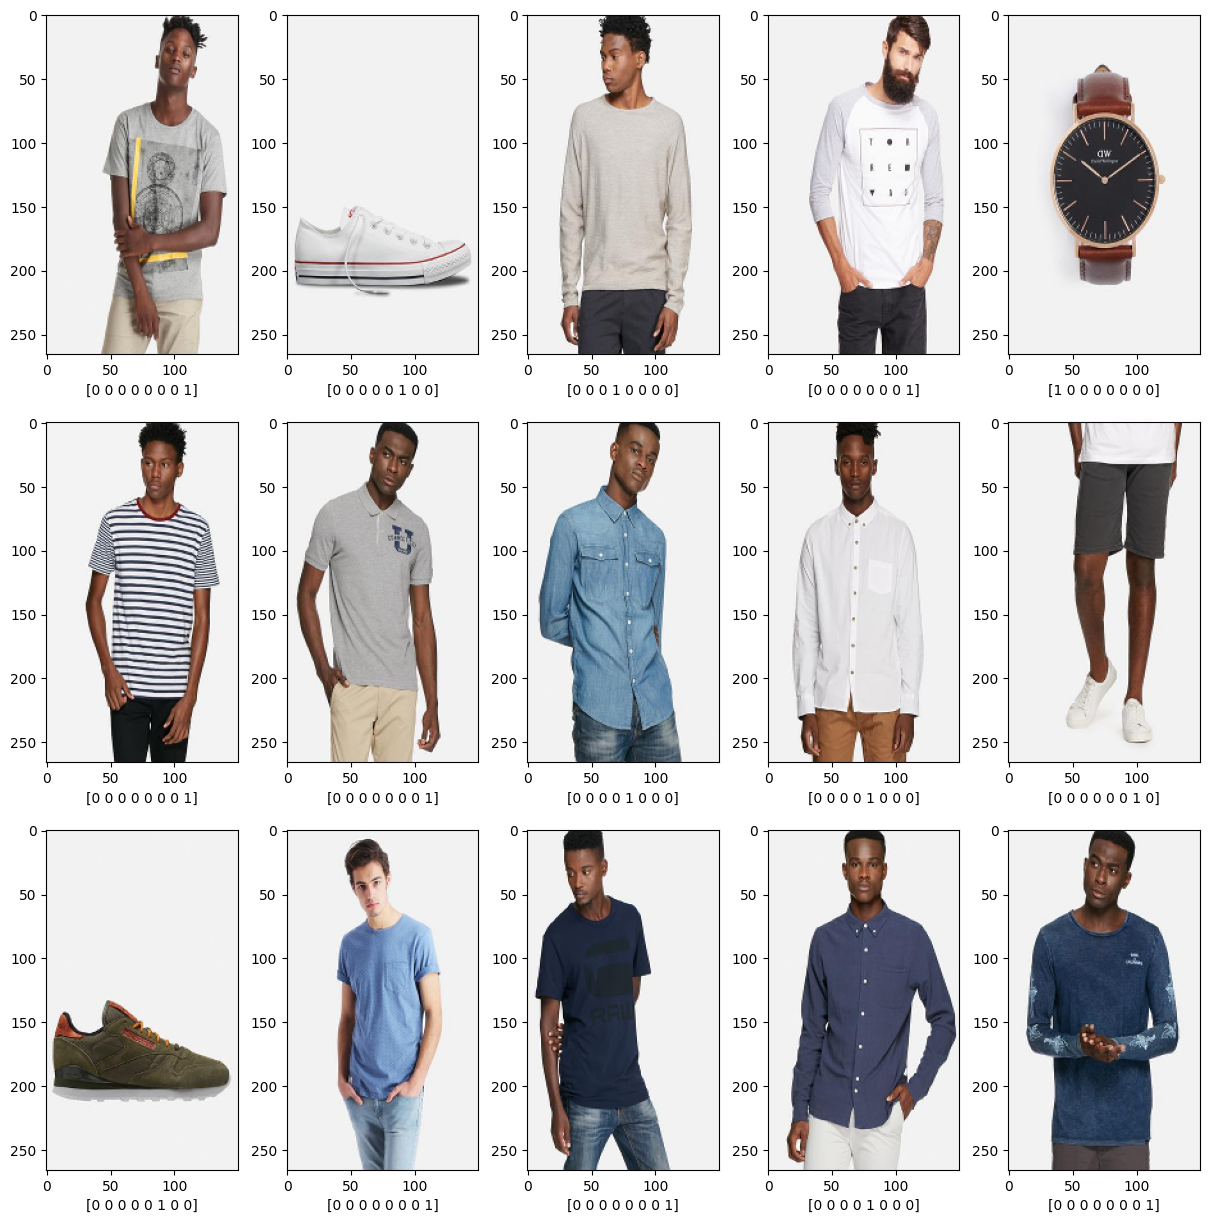

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,15))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(str(Y_train[i]))
    plt.sca(ax)
plt.show()


**2.1. Image calssification from-scratch**

Design your model from scratch with an architecture similar to that presented in the tutorial a typical CNN, in which the first part consists of Convolutional and max-pooling layers which act as the feature extractor. The second part consists of the fully connected layer which performs non-linear transformations of the extracted features and acts as the classifier.
For training the network, you follow the same workflow of create -> compile -> fit described above. Since it is a 8 class classification problem, you can use a categorical cross entropy loss and use RMSProp optimizer to train the network. Run it for some number of epochs (20 epochs)

In [9]:
# Model Design
# Feature extractor
model = models.Sequential() # (1)
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(266,
150, 3)))#(2)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) # (3)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Classifier
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) # (4)
model.add(layers.Dropout(0.5)) #Dropout for regularization # (5)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='softmax')) #
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 264, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 132, 74, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 130, 72, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 65, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 7, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,667,976 (25.44 MB)

 Trainable params: 6,667,976 (25.44 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Model compilation
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # Change 'lr' to 'learning_rate'
              metrics=['acc'])

In [11]:
# Image generation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255) #We do not augment validation data. we only perform rescale

In [12]:
from tensorflow.keras.callbacks import TensorBoard
NAME = "CNN_FromScratch"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [13]:
#Create the image generators
#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32
ntrain = len(X_train)
nval = len(X_val)
nb_epoch = 20

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

history = model.fit(train_generator,
                    steps_per_epoch = ntrain // batch_size,
                    epochs = nb_epoch,
                    validation_data = val_generator,
                    validation_steps = nval // batch_size,
                    callbacks=[tensorboard])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - acc: 0.4673 - loss: 1.5176 - val_acc: 0.7017 - val_loss: 0.8081
Epoch 2/20
  1/108 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - acc: 0.6875 - loss: 0.8529

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - acc: 0.6875 - loss: 0.8529 - val_acc: 0.7333 - val_loss: 0.6166
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.7532 - loss: 0.6787 - val_acc: 0.8040 - val_loss: 0.5480
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - acc: 0.7188 - loss: 0.6258 - val_acc: 0.8333 - val_loss: 0.4383
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - acc: 0.7839 - loss: 0.5572 - val_acc: 0.8523 - val_loss: 0.4372
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step - acc: 0.8750 - loss: 0.4608 - val_acc: 0.8000 - val_loss: 0.4942
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - acc: 0.8468 - loss: 0.4134 - val_acc: 0.8807 - val_loss: 0.3631
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step - acc: 0.8750 - loss: 0.3793 - val_acc: 0.8667 - val_loss: 0.3764
Epoch 9/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - acc: 0.8697 - loss: 0.3534 - val_acc: 0.8210 - val_loss: 0.3970
Epoch 10/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
import datetime
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [ ]:
model.save_weights('model_keras.weights.h5')
model.save('model_keras.h5')

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

**2.2. With Data Augmentation**

One of the major reasons for overfitting is that you don’t have enough data to train your network. Apart from regularization, another very effective way to counter Overfitting is Data Augmentation. It is the process of artificially creating more images from the images you already have by changing the size, orientation etc of the image. It can be a tedious task but fortunately, this can be done in Keras using the ImageDataGenerator instance. Similare to above, train your model with Data Augmentation. Plot performance curves that show the evaluation of your model (TensorBoard with Keras is via a Keras callback).

In [ ]:
# Model compilation
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4), # Change 'lr' to 'learning_rate'
              metrics=['acc'])

In [ ]:
# Image generation
train_datagen = ImageDataGenerator(rescale=1./255, #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255) #We do not augment validation data. we only perform rescale

In [ ]:
#Create the image generators
#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32
ntrain = len(X_train)
nval = len(X_val)
nb_epoch = 20

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

history = model.fit(train_generator,
                    steps_per_epoch = ntrain // batch_size,
                    epochs = nb_epoch,
                    validation_data = val_generator,
                    validation_steps = nval // batch_size,
                    callbacks=[tensorboard])

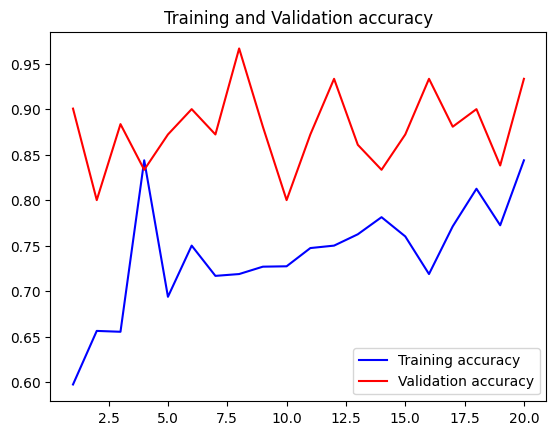

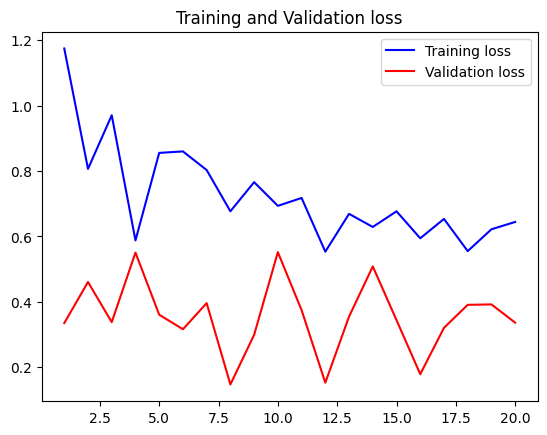

In [23]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Assez surprenemment, la fonction de coût est moins minimisée que pour les données non augmentées.

**2.3. Image classification using different pre-trained models**

ImageNet Large Scale Visual Recognition Challenge ([ILSVRC](https://image-net.org/challenges/LSVRC/2017/index)) is an annual competition organized by the ImageNet team since 2010, where research teams evaluate their computer vision algorithms various visual recognition tasks such as Object Classification and Object Localization. The training data is a subset of ImageNet with 1.2 million images belonging to 1000 classes.

The winners of ILSVRC have been very generous in releasing their models to the open-source community. There are many models such as AlexNet, VGGNet, Inception, ResNet, Xception and many more which we can choose from, for our own task. Apart from the ILSVRC winners, many research groups also share their models which they have trained for similar tasks, e.g, MobileNet, SqueezeNet etc.
These networks are trained for classifying images into one of 1000 categories or classes.
In order to perform tests with these models, We can load the models in Keras using the following code:

Compare results from various models on several images.
We can conclude from obtained results that to have a good performance on our own dataset, we have to train a classifier using these same models with our own data to recognize any other set of objects which are not present in the ILSVRC dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━

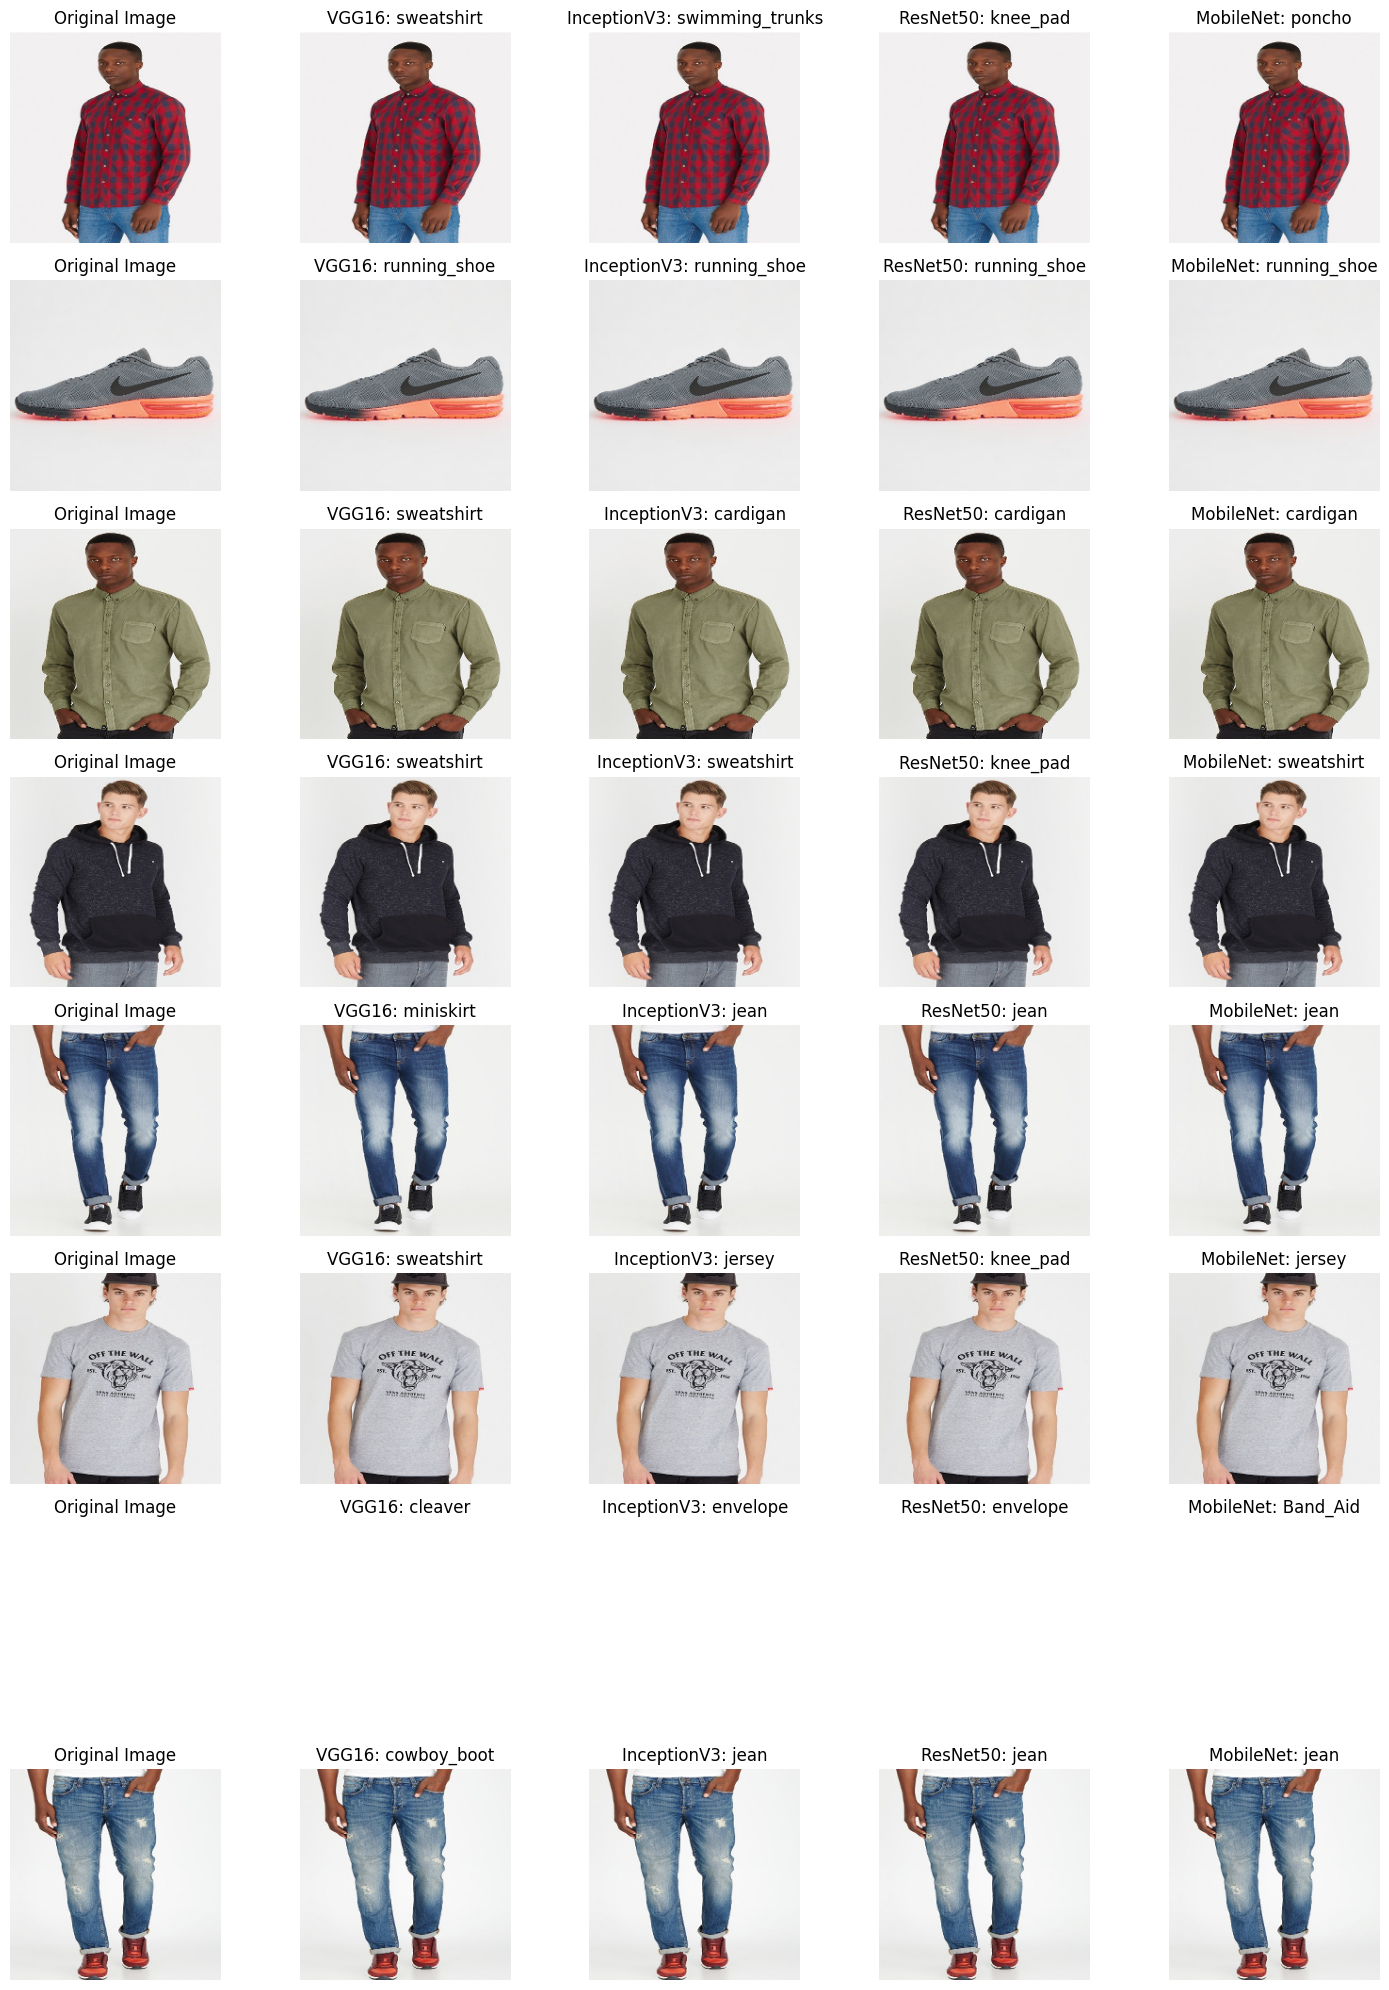

In [28]:
import numpy as np
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import builtins


# Define input shapes for each model
input_shapes = {
    vgg16: (224, 224),
    inception_v3: (299, 299),
    resnet50: (224, 224),
    mobilenet: (224, 224),
}

# ... (read_process, read_process_test functions remain unchanged) ...

X_test = read_process_test(224, 224)
model_names = ["VGG16", "InceptionV3", "ResNet50", "MobileNet"]
models_list = [vgg16, inception_v3, resnet50, mobilenet]
pretrained_models = [vgg16.VGG16(weights='imagenet'),
                     inception_v3.InceptionV3(weights='imagenet'),
                     resnet50.ResNet50(weights='imagenet'),
                     mobilenet.MobileNet(weights='imagenet')]

num_images = min(len(X_test), 10)  # Display up to 10 images

fig, axs = plt.subplots(nrows=num_images, ncols=len(model_names) + 1, figsize=(15, 20))

for i in range(num_images):
    # Display original image
    axs[i, 0].imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    axs[i, 0].set_title("Original Image")
    axs[i, 0].axis('off')

    for j, (model_name, model, pretrained_model) in enumerate(builtins.zip(model_names, models_list, pretrained_models)):
        # Resize image
        model_input_shape = input_shapes[model]
        resized_image = tf.image.resize(X_test[i][np.newaxis, ...], model_input_shape)

        # Preprocess and predict
        processed_image = model.preprocess_input(resized_image)
        predictions = pretrained_model.predict(processed_image)

        # Decode predictions
        decoded_predictions = model.decode_predictions(predictions, top=1)

        # Display prediction
        axs[i, j + 1].imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
        axs[i, j + 1].set_title(f"{model_name}: {decoded_predictions[0][0][1]}")
        axs[i, j + 1].axis('off')

plt.tight_layout()
plt.show()

On obtient les résultats suivants:


*   VGG16 : 2/7
*   InceptionV3 : 6/7
*   ResNet50 : 4/7
*   MobileNet : 6/7

Les modèles InceptionV3 et MobileNet ont de meilleurs résultats que VGG16 et ResNet50, pour approfondir l'étude, on pourrait imaginer tester chacun des modèles sur un plus grand ensemble de données.


**2.4	Transfer Learning using pre-trained models:**

The pre-trained models are trained on very large-scale image classification problems. The convolutional layers act as feature extractor and the fully connected layers act as Classifiers. Since these models are very large and have seen a huge number of images, they tend to learn very good, discriminative features. When we have a small training set and our problem is similar to the task for which the pre-trained models were trained, we can use transfer learning.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet. You can import the VGG16 model which comes pre-packaged in Keras from the keras.applications module. Start by instantiate it by passing three arguments to the constructor:
o	weights, to specify which weight checkpoint to initialize the model from
o	include_top, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
o	input_shape, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size. In our case, the image size is 224.

In [14]:
from tensorflow.keras.applications import VGG16

batch_size=32

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

Print the detail of the architecture of the VGG16 convolutional base. You can see that the final feature map has shape (7, 7, 512). That's the feature on top of which we will stick a densely-connected classifier. At this point, there are two ways we could proceed:
o	Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have developed in the from-scratch version.
o	Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, this technique is more expensive than the first one.

**1st technique of feature extraction**:
Start as above by loading the images using the ImageDataGenerator class and then generate batches of images and labels using the function flow_from_directory.
Then, we use model.predict() function to pass the image through the network which gives us a 7 x 7 x 512 dimensional Tensor. We reshape the Tensor into a vector. Similarly, we find the validation_features.

In [15]:
X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

nTrain = len(X_train)
nVal = len(X_val)

train_features,val_features = conv_base.predict(X_train),conv_base.predict(X_val)
train_features,val_features = np.reshape(train_features, (nTrain, 7 * 7 * 512)),np.reshape(val_features, (nVal, 7 * 7 * 512))

print(train_features.shape,Y_train.shape)
print(val_features.shape,Y_val.shape)


109/109 ━━━━━━━━━━━━━━━━━━━━ 32s 182ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
(3467, 25088) (3467, 8)
(382, 25088) (382, 8)


So for each image we obtain 512 features of size 7x7. We flatten them and process them through our classifier. As an example we plot some of these intermediary features (9 feature maps of size 28x28)).

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


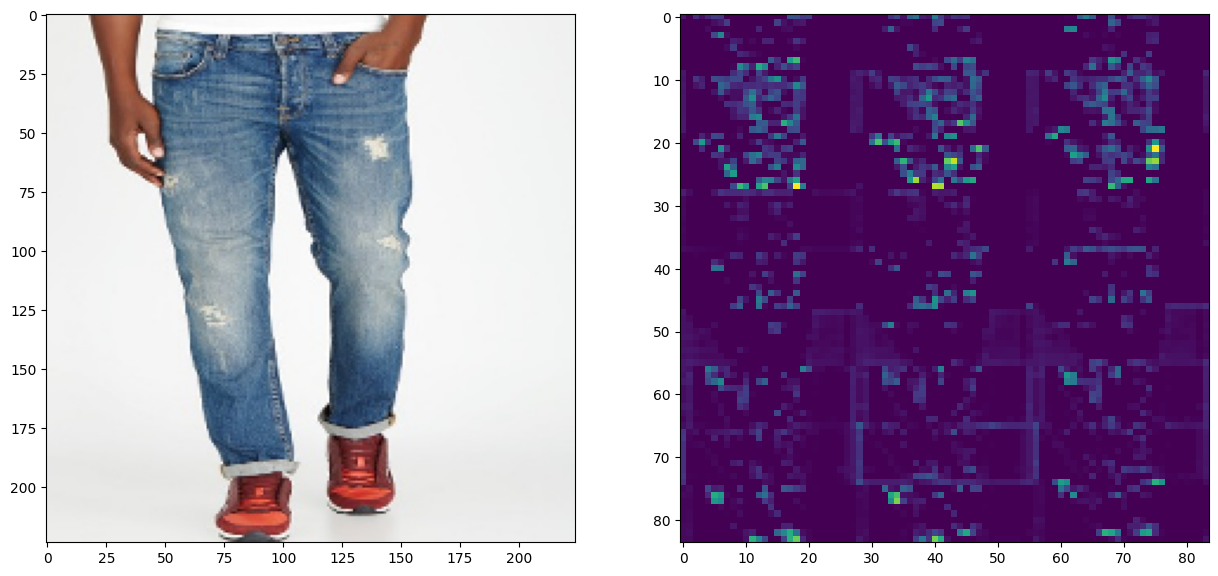

In [16]:
X_test=read_process_test(224,224)[-1]
conv_base_demo = models.Sequential()
for i in range(11):
    conv_base_demo.add(conv_base.layers[i])
predictions = conv_base_demo.predict(np.array([X_test]))

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.imshow(cv2.cvtColor(X_test, cv2.COLOR_BGR2RGB))
output=[]
for i in range(3):
    row=[]
    for j in range(3):
        pred=predictions[0,:,:,3*i+j]
        row.append(pred)
    output.append(row)
ax2.imshow(np.reshape(output,(84,84)))
plt.show()

At this point, we can define our densely-connected classifier (note the use of dropout for regularization) layer having 3 classes, and train it on the data and labels that we just recorded:


Train the network by calling model12.compile() then model.fit() function as we have seen in our earlier exercise, and check its performance.


In [17]:
# Define the model (model2)
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(8, activation='softmax'))

# Compile the model
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Train the model
history = model2.fit(
    train_features, Y_train,
    epochs=20,  # Adjust the number of epochs as needed
    batch_size=32,
    validation_data=(val_features, Y_val))

# Evaluate the model
loss, accuracy = model2.evaluate(val_features, Y_val, verbose=0)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - acc: 0.7340 - loss: 5.8254 - val_acc: 0.9136 - val_loss: 0.5408
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9124 - loss: 0.7385 - val_acc: 0.8848 - val_loss: 0.9716
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9383 - loss: 0.4108 - val_acc: 0.9476 - val_loss: 0.3206
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9519 - loss: 0.3105 - val_acc: 0.9424 - val_loss: 0.3657
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9665 - loss: 0.1720 - val_acc: 0.9634 - val_loss: 0.2980
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9672 - loss: 0.1586 - val_acc: 0.9712 - val_loss: 0.2216
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc: 0.9735 - loss: 0.1438 - val_acc: 0.9476 - val_loss: 0.5800
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.9849 - loss: 0.1102 - val_acc: 0.9607 - val_loss: 0.4321
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - a

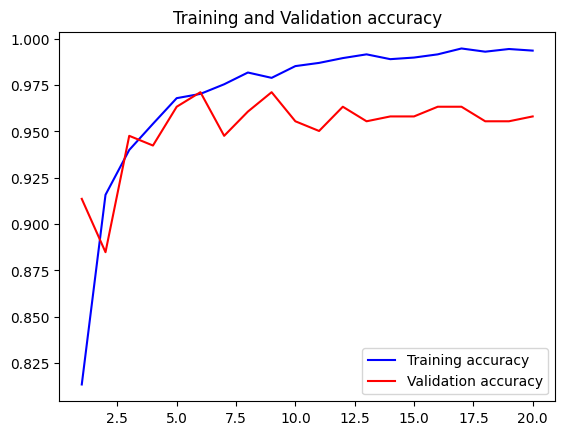

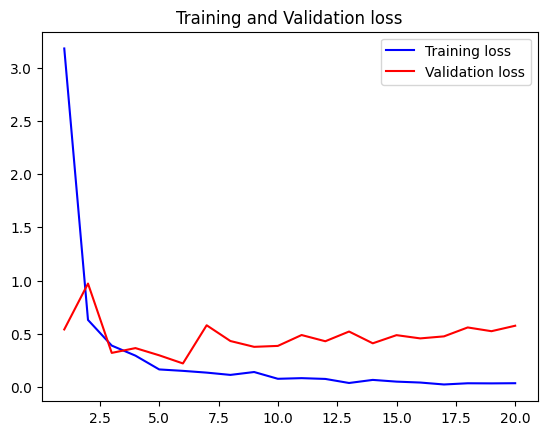

In [18]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

On peut voir que la précision est assez bonne elle oscille aux alentours de 0.96.

**Train more layers in the architecture**
If you train more layers in the proposed architecture you will certainly obtain a better accuracy. For example, freeze the network except the three last weight layers.

If you would like to visualize how images were classified, you can use this part of code:

In [54]:
# labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
# X_test=read_process_test(224,224)
# Y_test=model2.predict(np.reshape(conv_base.predict(X_test/255),(len(X_test),7*7*512)))
# fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
# for i, ax in enumerate(axs.flatten()):
#     plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
#     plt.xlabel(labels[np.argmax(Y_test[i])])
#     plt.sca(ax)
# plt.show()

In [ ]:
'''fnames = validation_generator.filenames
ground_truth = validation_generator.classes
label2index = validation_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.iteritems())
predictions = model12.predict_classes(validation_features)
prob = model12.predict(validation_features)

# to see which images were predicted wrongly
errors = np.where(predictions != ground_truth)[0]print("No of errors = {}/{}".format(len(errors), nVal))
for i in range(len(errors)):
  pred_class = np.argmax(prob[errors[i]])
  pred_label = idx2label[pred_class]
  print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(fnames[errors[i]].split('/')[0],        pred_label,        prob[errors[i]][pred_class]))    original = load_img('{}/{}'.format(validation_dir, fnames[errors[i]]))    plt.imshow(original)    plt.show()
'''

**2nd technique of feature extraction**:
consists of extending the conv_base model and running it end-to-end on the inputs. So you can do the following:

In [20]:
model12 = models.Sequential()
model12.add(conv_base)
model12.add(layers.Flatten())
model12.add(layers.Dense(256, activation='relu'))
model12.add(layers.Dense(8, activation='sigmoid'))

This is what our model looks like now:


In [21]:
model12.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,528 (80.64 MB)

 Trainable params: 21,139,528 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 6 million parameters. Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. In Keras, freezing a network is done by setting its trainable attribute to False:

In [22]:
conv_base.trainable = False

With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Now we can start training our model, with optionally a data augmentation configuration that we used in our previous exercise:

In [23]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                   width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   vertical_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

Train the network by calling model.fit() function and check its performance as we have seen above.

In [25]:
# Compile the model
model12.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

history = model12.fit(train_generator,
                    steps_per_epoch = ntrain // batch_size,
                    epochs = nb_epoch,
                    validation_data = val_generator,
                    validation_steps = nval // batch_size,
                    callbacks=[tensorboard])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 98/108 ━━━━━━━━━━━━━━━━━━━━ 4s 427ms/step - acc: 0.5808 - loss: 1.3366

KeyboardInterrupt: 

**2.5. Fine-Tuning a pre-trained model**

Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. As explained later in the course, the initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact (or freeze them) and retrain the later layers for our task. Note also that, the more parameters we are training, the more we are at risk of overfitting.

First, we will load a VGG model without the top layer (which consists of fully connected layers). Then, we will fine-tune the last 4 layers:

In [ ]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in conv_base.layers[:-4]:
  layer.trainable = False
  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
    print(layer, layer.trainable)

Now that we have set the trainable parameters of our base network, we would like to add a classifier on top of the convolutional base, and set up the data for training exactly like the previous exercise. Check out the performance. To see the effect of fine-tuning and data augmentation, you can perform experiments with and without data augmentation, and with freezing all layers and learning a classifier on top of it, similar to transfer learning, and training the last 3 convolutional layers.